# <center>Modeling and forecasting atmospheric $CO_2$</center>
## <center>Source Code</center>
### <center>Taha Bouhoun</center>

In [74]:
# Importing packages
import numpy as np
import pandas as pd
import scipy.stats as sts
import PIL
from datetime import*
from math import*
import matplotlib.pyplot as plt
from IPython.display import*
import pystan

%matplotlib inline

In [177]:
data = pd.read_csv('weekly_in_situ_co2_mlo.csv', 
                    skiprows = list(range(44)),
                    names=['Date', 'Meas'])

data['Date'] =  pd.to_datetime(data['Date'])
data['Time'] = (data.Date - data.Date[0]).dt.days
future = [data.Time.iloc[-1] + x*7 for x in range(2080)]

print('Missing data:',
      data.isnull().values.any())
display(data.Meas.describe().transpose())
display(data.head(10))

Missing data: False


count    3139.000000
mean      355.081934
std        27.999040
min       313.040000
25%       329.800000
50%       352.590000
75%       377.480000
max       415.080000
Name: Meas, dtype: float64

,Date,Meas,Time
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28
5,1958-05-03,316.95,35
6,1958-05-17,317.56,49
7,1958-05-24,317.99,56
8,1958-07-05,315.85,98
9,1958-07-12,315.85,105


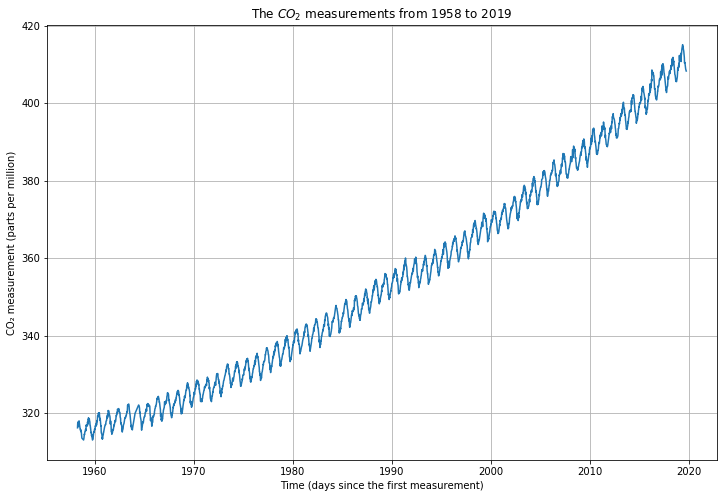

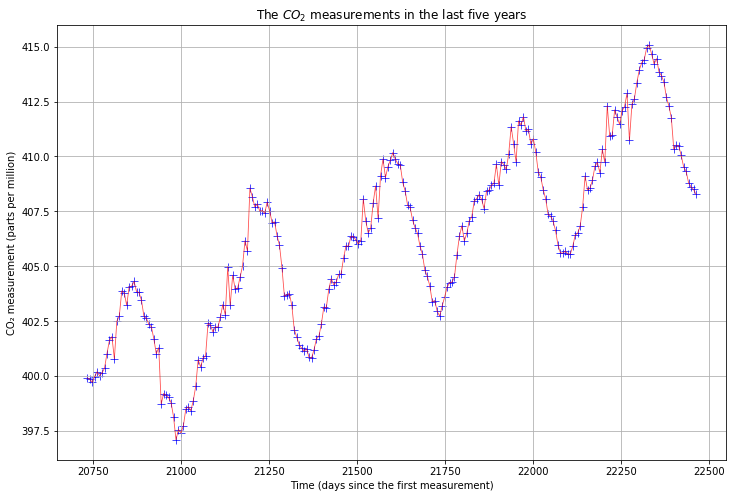

In [178]:
# Plotting the measurements
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Meas'])
plt.title('The $CO_2$ measurements from 1958 to 2019', 
          fontsize=12)
plt.ylabel('CO₂ measurement (parts per million)')
plt.xlabel('Time (days since the first measurement)')
plt.grid(True)
plt.show()


# Plotting the measurements of the last five years
plt.figure(figsize=(12, 8))
plt.scatter(data.iloc[2891:]['Time'],
            data.iloc[2891:]['Meas'], s=50, linewidth=.7,
            marker='+', color='blue')
plt.plot(data.iloc[2891:]['Time'], data.iloc[2891:]['Meas'], 
         linewidth=.8, alpha=.7, color='red')
plt.title('The $CO_2$ measurements in the last five years', 
          fontsize=12)
plt.ylabel('CO₂ measurement (parts per million)')
plt.xlabel('Time (days since the first measurement)')
plt.grid(True)
plt.show()

## Modeling

In [179]:
Stan_data = {
    'n' : len(data),
    'time' : list(data.Time) + future,
    'n_f': len(data) + 2080, 
    'meas' : data.Meas.values}

In [180]:
# GRAPHING FUNCTION
def graphing(gen_quan):
    
    rep_meas = []
    for i in range(len(Stan_data['time'])):
        rep_meas.append(np.mean(gen_quan[:,i]))

    # Plot the whole period
    plt.figure(figsize=(12, 8))
    plt.plot(data.Time, rep_meas[:3139], label='Replication',
                linewidth=.5, color='blue')          
    plt.plot(data.Time, data.Meas, label='Observation',
                linewidth=.5, color='red')
    plt.title('The $CO_2$ measurements from 1958 to 2019', fontsize=12)
    plt.ylabel('$CO_2$ measurement (parts per million)')
    plt.xlabel('Time (days since the first measurement)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot the last five years
    plt.figure(figsize=(12, 8))
    plt.scatter(data.Time[2891:3139], rep_meas[2891:3139], 
             s=10, linewidth=.7, marker='+', color='blue',
             label='Replication')
    plt.scatter(data.Time[2891:3139], data.iloc[2891:3139]['Meas'], 
             s=10, linewidth=.7, marker='+', color='red',
             label='Observation')
    plt.title('The $CO_2$ measurements in the last five years', 
              fontsize=12)
    plt.ylabel('$CO_2$ measurement (parts per million)')
    plt.xlabel('Time (days since the first measurement)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    # Residual graph
    resid = data.Meas - rep_meas[:3139]
    plt.figure(figsize=(12, 8))
    plt.plot(data.Time, resid, linewidth=.8)
    plt.axhline(0, color='red',linewidth=.5)
    plt.xlabel('Time (days since the first measurement)')
    plt.ylabel('$CO_2$ level (parts per million)')
    plt.title('Residuals of $CO_2$ level Predictions')
    plt.show()

In [181]:
# TESTING THE SIMULATION: [PAIR PLOTS, AUTOCORRELATION]
# Code from session 14.1 [CS146]
import seaborn as sn
from scipy import signal

def pair_autocorr(results, parameters):
    pp = pd.DataFrame(
        data=np.transpose([results[_] 
                          for _ in parameters]),
        columns=parameters)
    sn.pairplot(pp, height=2.5, 
                plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

    def plot_acf(x):
        plt.acorr(x, maxlags=20, 
                  detrend=lambda x: signal.detrend
                  (x, type='constant'))

    for _ in parameters:
        plt.figure(figsize=(12, 4))
        plot_acf(results[_])
        plt.title(f'Autocorrelation of {_} samples')
    plt.show()

In [182]:
Stan_code1 = """
data {
    int<lower=0> n;          // number of measurements
    real<lower=0> meas[n];   // measurement of Carbon Dioxide
    int<lower=0> n_f;        // measurements + projections
    real<lower=0> time[n_f]; // days since the first measurement
}

parameters {
    real<lower=0> c0;          
    real c1;
    real c2;
    real c3;
    real<lower=0> c4;
}

model {
    c0 ~ cauchy(0, 5);     // intercept
    c1 ~ cauchy(0, 5);     // slope of the linear trend
    c2 ~ cauchy(0, 5);     // amplitude
    c3 ~ cauchy(0, 5);     // phase
    c4 ~ cauchy(0, 5);     // the variance of the noise
    
    for (i in 1:n) {
        meas[i] ~ normal(c0 + c1 * time[i] + c2 * 
        cos(((2 * pi() * time[i]) / 365.25) + c3), c4);
    }
}
generated quantities{
    real meas_f[n_f];
    for(t in 1:n_f){
        meas_f[t] = normal_rng(c0 + c1 * time[t] + c2 * 
        cos(((2 * pi() * time[t]) / 365.25) + c3), c4);
    }
}
"""

In [183]:
Stan_model = pystan.StanModel(model_code=Stan_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d0181e9ecb1dccadbd5774c5daf4f324 NOW.


In [184]:
Stan_results1 = Stan_model.sampling(data=Stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [185]:
param_1 = ['c0','c1','c2','c3','c4']
print(Stan_results1.stansummary(pars=param_1))

Inference for Stan model: anon_model_d0181e9ecb1dccadbd5774c5daf4f324.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 306.09  2.3e-3   0.14 305.82  306.0 306.09 306.19 306.36   3456    1.0
c1 4.3e-3  1.8e-7 1.1e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   3492    1.0
c2  -1.44    1.77   2.51  -3.06  -2.93  -2.85   0.25   3.02      2  29.29
c3   1.92    0.96   1.36  -0.48   0.98   2.69   2.72   2.77      2  43.49
c4   3.75  1.7e-3   0.05   3.65   3.71   3.74   3.78   3.84    797   1.01

Samples were drawn using NUTS at Fri Dec 20 01:52:30 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


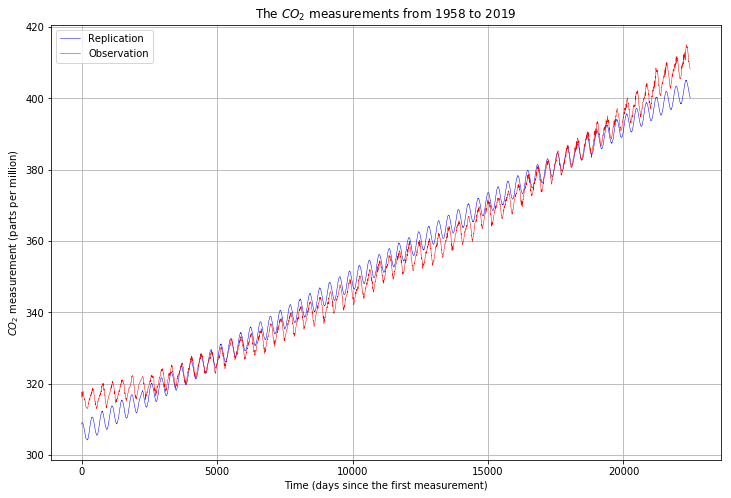

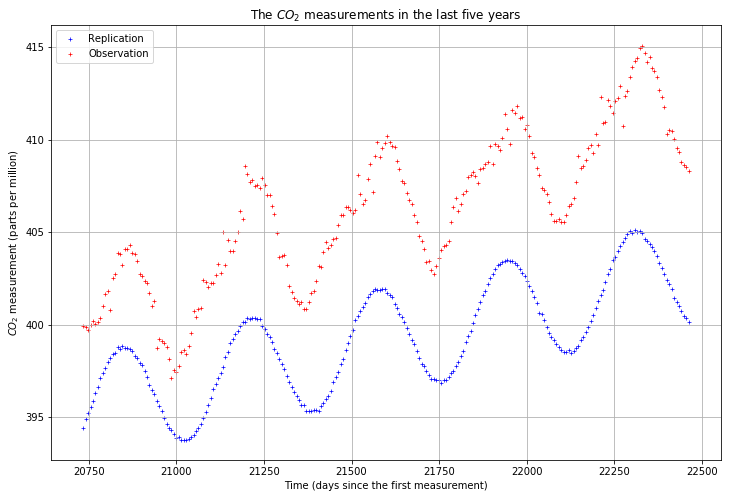

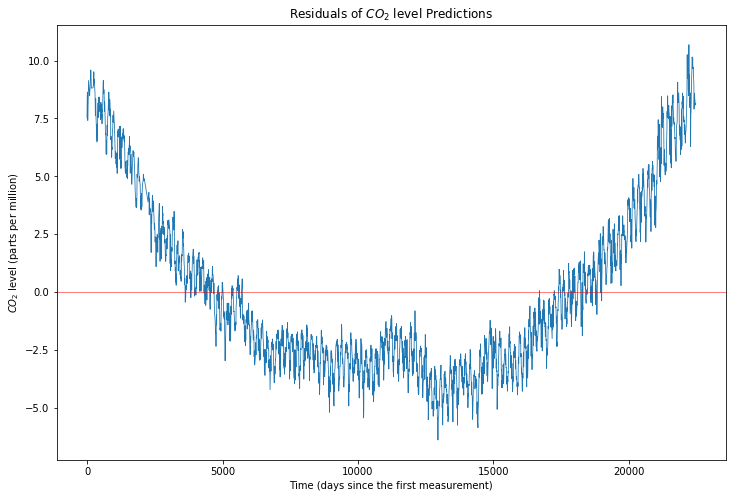

In [186]:
r1 = Stan_results1.extract()
graphing(r1['meas_f'])

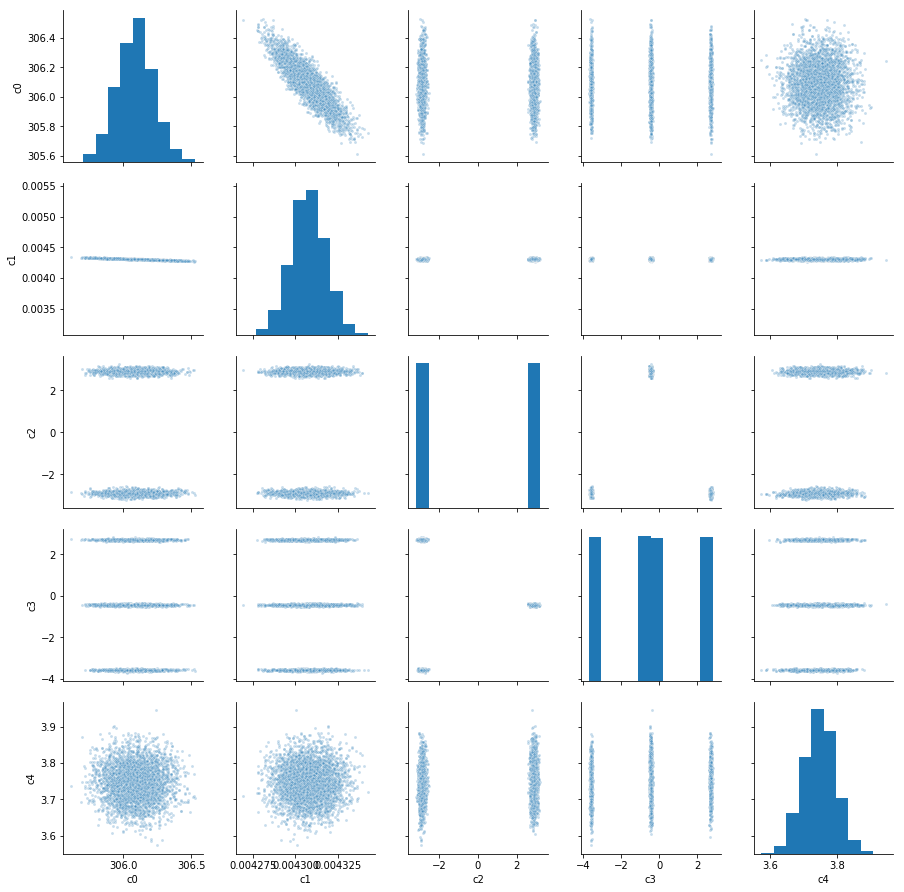

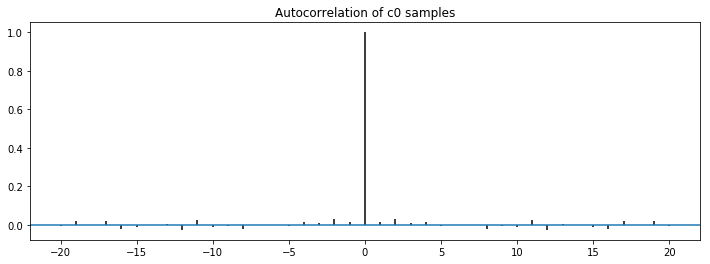

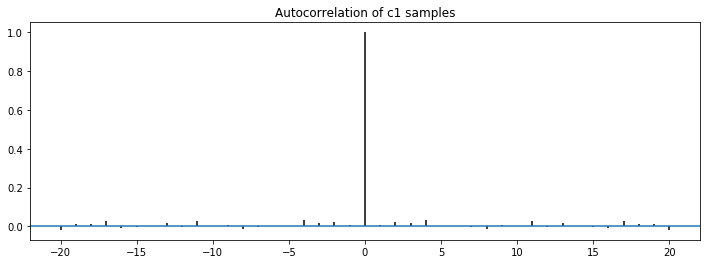

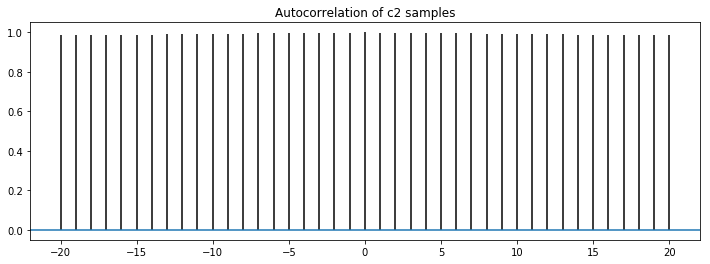

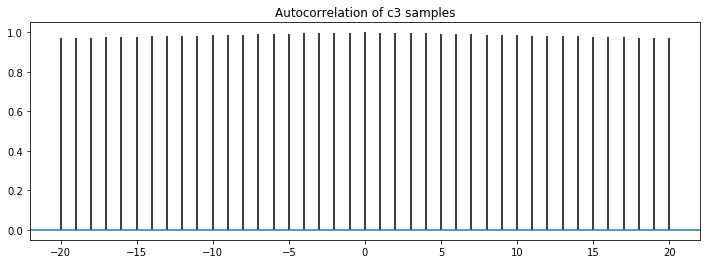

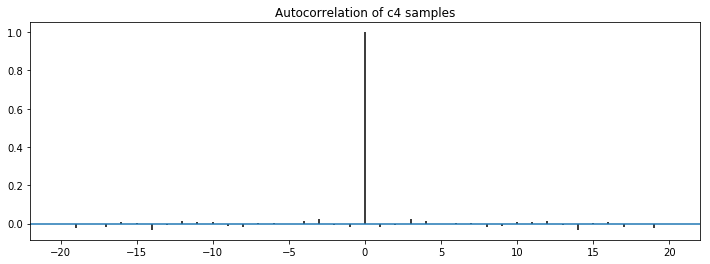

In [15]:
pair_autocorr(r1, param_1)

---

In [17]:
Stan_code2 = """

data {
    int<lower=0> n;          // number of measurements
    real<lower=0> meas[n];   // measurement of Carbon Dioxide
    int<lower=0> n_f;        // measurements + projections
    real<lower=0> time[n_f]; // days since the first measurement
}

parameters {
    real<lower=0> c0;          
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0, upper=pi()> c4;
    real<lower=0> c5;
}

model {
    c0 ~ normal(315, 5);   // intercept
    c1 ~ normal(0, 1);     // linear coeff
    c2 ~ normal(0, 1);     // quadratic coeff
    c3 ~ normal(2, 1);     // amplitude
    c4 ~ normal(pi(), 1);  // phase
    c5 ~ cauchy(0, 1);     // the variance of the noise
    
    for (i in 1:n) {
        meas[i] ~ normal(c0 + c1 * time[i] + c2 * (time[i])^2 +
        c3 * cos(((2 * pi() * time[i]) / 365.25) + c4), c5);
    }
}
generated quantities{
    real meas_f[n_f];
    for(t in 1:n_f){
        meas_f[t] = normal_rng(c0 + c1 * time[t] + c2 * (time[t])^2 +
        c3 * sin(((2 * pi() * time[t]) / 365.25) + c4), c5);
    }
}
"""

In [18]:
Stan_model = pystan.StanModel(model_code=Stan_code2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4544fe6f76c543831c94d3c49ded478d NOW.


In [19]:
Stan_results2 = Stan_model.sampling(data=Stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [20]:
param_2 = ['c0','c1','c2','c3','c4','c5']
print(Stan_results2.stansummary(pars=param_2))

Inference for Stan model: anon_model_4544fe6f76c543831c94d3c49ded478d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 314.59  2.0e-3   0.07 314.45 314.54 314.59 314.64 314.73   1256    1.0
c1 2.1e-3  4.8e-7 1.4e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3    870    1.0
c2 9.7e-8 2.1e-116.1e-10 9.6e-8 9.7e-8 9.7e-8 9.8e-8 9.9e-8    862    1.0
c3   2.62  5.8e-4   0.03   2.56    2.6   2.62   2.64   2.68   2906    1.0
c4 3.4e-4  6.8e-6 3.6e-4 6.3e-6 9.4e-5 2.3e-4 4.7e-4 1.3e-3   2790    1.0
c5   1.28  3.0e-4   0.02   1.25   1.27   1.28   1.29   1.31   3019    1.0

Samples were drawn using NUTS at Thu Dec 19 13:03:36 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


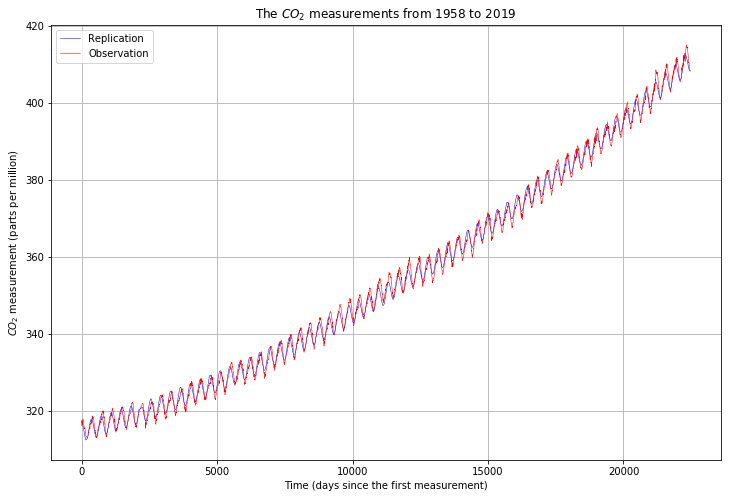

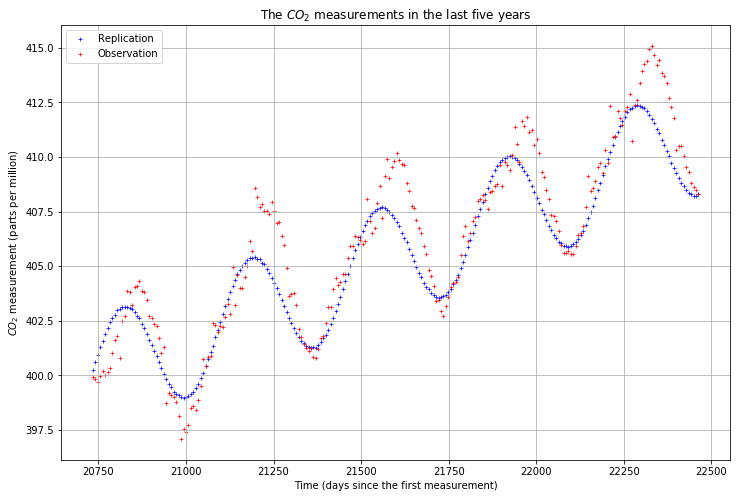

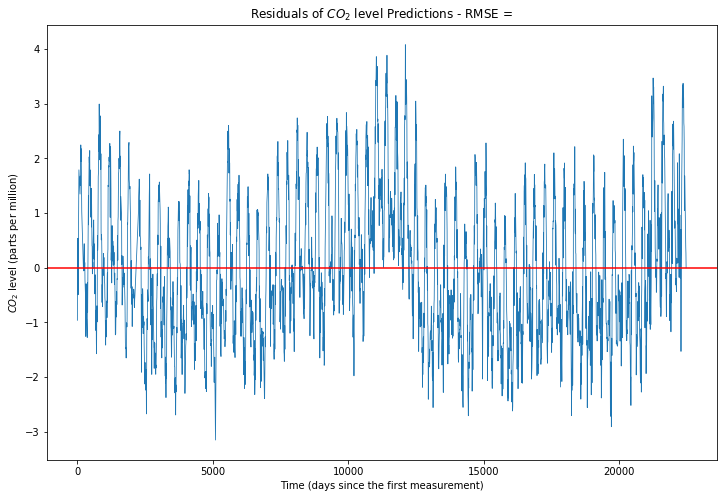

In [21]:
r2 = Stan_results2.extract()
graphing(r2['meas_f'])

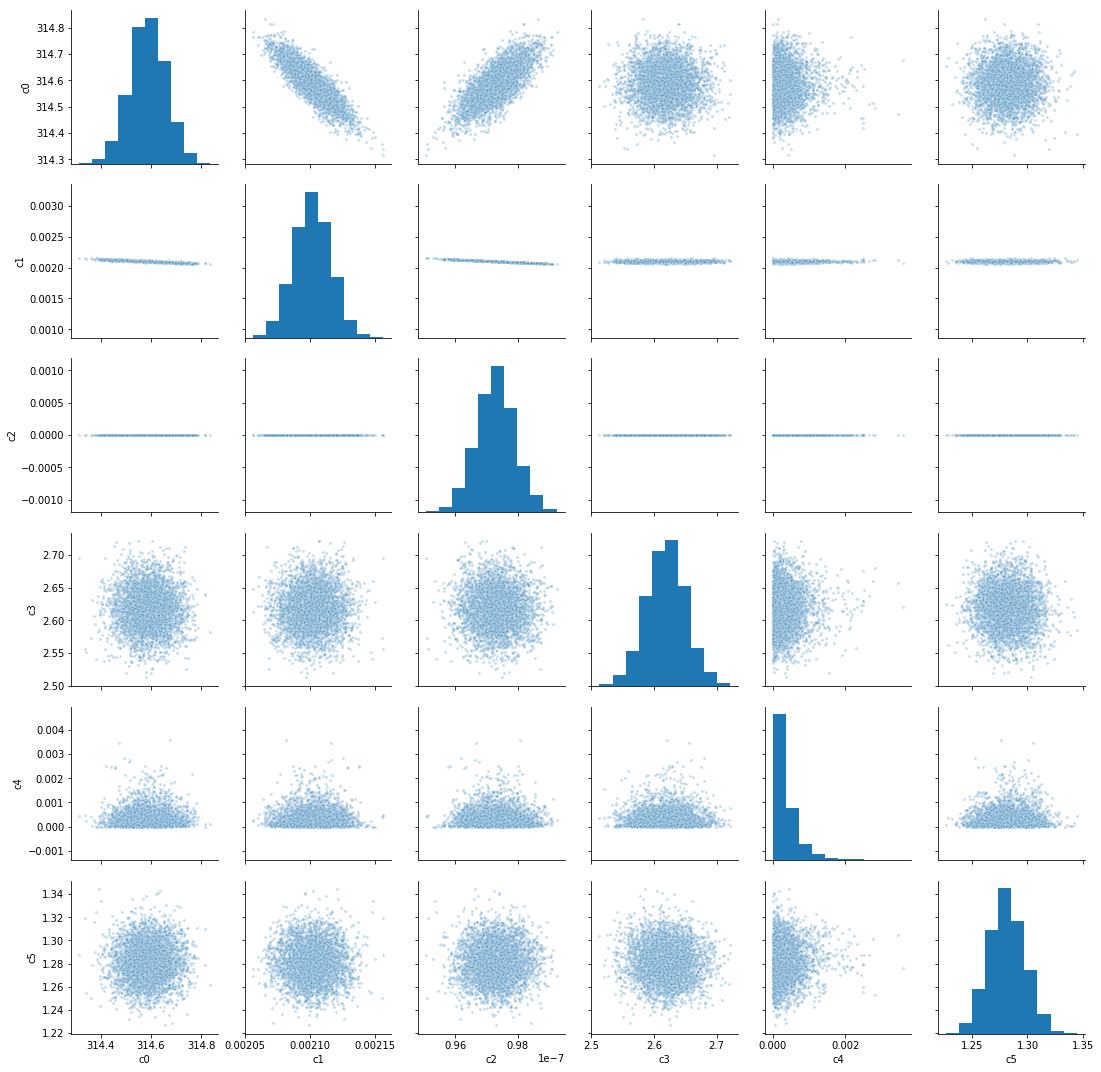

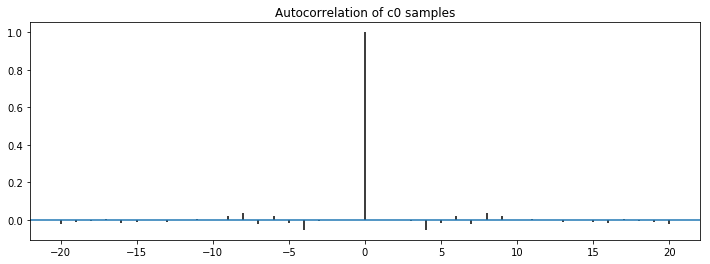

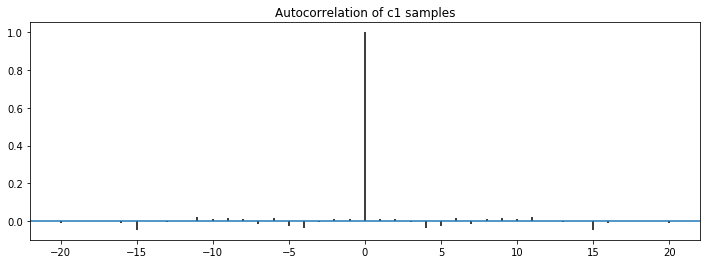

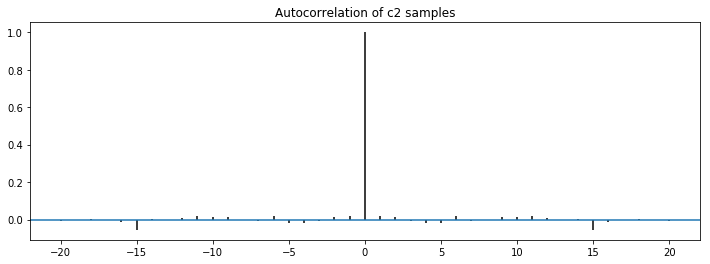

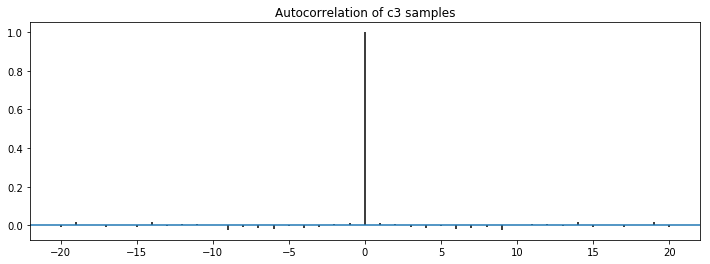

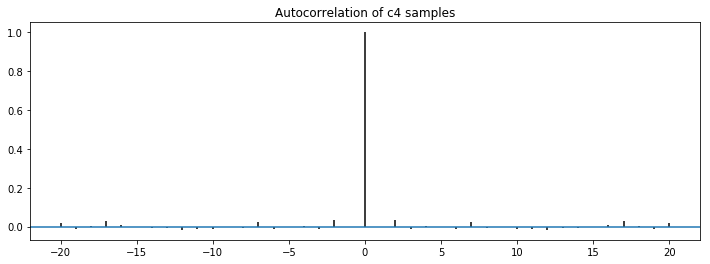

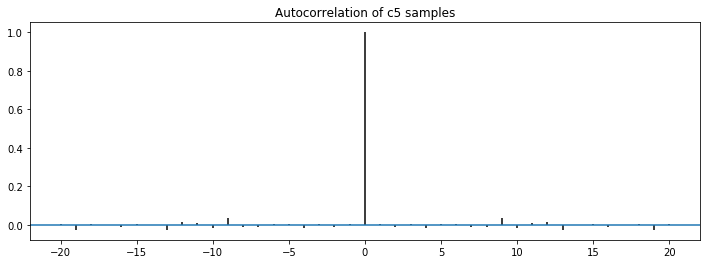

In [22]:
pair_autocorr(r2, param_2)

---

In [29]:
Stan_code3 = """

data {
    int<lower=0> n;          // number of measurements
    real<lower=0> meas[n];   // measurement of Carbon Dioxide
    int<lower=0> n_f;        // measurements + projections
    real<lower=0> time[n_f]; // days since the first measurement
}

parameters {
    real<lower=0> c0;          
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0> c4;
    real<lower=0> c5;
    real<lower=0> phi;
}

model {
    c0 ~ normal(315, 5);   // intercept
    c1 ~ normal(0, 1);     // linear coeff
    c2 ~ normal(0, 1);     // quadratic coeff
    c3 ~ cauchy(0, 1);     // amplitude 1
    c4 ~ cauchy(0, 1);     // amplitude 2
    phi ~ cauchy(0, 1);    // phase
    c5 ~ normal(0, 1);     // noise
        
    for (i in 1:n) {
        meas[i] ~ normal(c0 + c1 * time[i] + c2 * (time[i])^2 +
        c3 * sin(((2 * pi() * time[i]) / 365.25) + phi) +
        c4 * sin(((4 * pi() * time[i]) / 365.25) + phi), c5);
    }
}
generated quantities {
    real meas_f[n_f];
    for(t in 1:n_f){
        meas_f[t] = normal_rng(c0 + c1 * time[t] + c2 * (time[t])^2 +
        c3 * sin(((2 * pi() * time[t]) / 365.25) + phi) +
        c4 * sin(((4 * pi() * time[t]) / 365.25) + phi), c5);
    }
}
"""

In [30]:
Stan_model = pystan.StanModel(model_code=Stan_code3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_42637ee5484d5134fe0f739f9b3d4c36 NOW.


In [31]:
Stan_results3 = Stan_model.sampling(data=Stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [32]:
param_3 = ['c0','c1','c2','c3','c4','c5','phi']
print(Stan_results3.stansummary(pars=param_3))

Inference for Stan model: anon_model_42637ee5484d5134fe0f739f9b3d4c36.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0  314.57  1.1e-3   0.05 314.46 314.53 314.57 314.61 314.67   2667    1.0
c1  2.1e-3  2.3e-7 1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   2294    1.0
c2  9.7e-8 9.5e-124.7e-10 9.6e-8 9.7e-8 9.7e-8 9.7e-8 9.8e-8   2427    1.0
c3    2.86  4.4e-4   0.03   2.81   2.84   2.86   2.88   2.91   3327    1.0
c4  1.2e-3  1.9e-5 1.2e-3 3.2e-5 3.7e-4 8.6e-4 1.7e-3 4.5e-3   4128    1.0
c5    0.99  2.0e-4   0.01   0.96   0.98   0.99   0.99   1.01   3774    1.0
phi   1.15  1.5e-4 8.8e-3   1.14   1.15   1.15   1.16   1.17   3305    1.0

Samples were drawn using NUTS at Thu Dec 19 19:58:29 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergenc

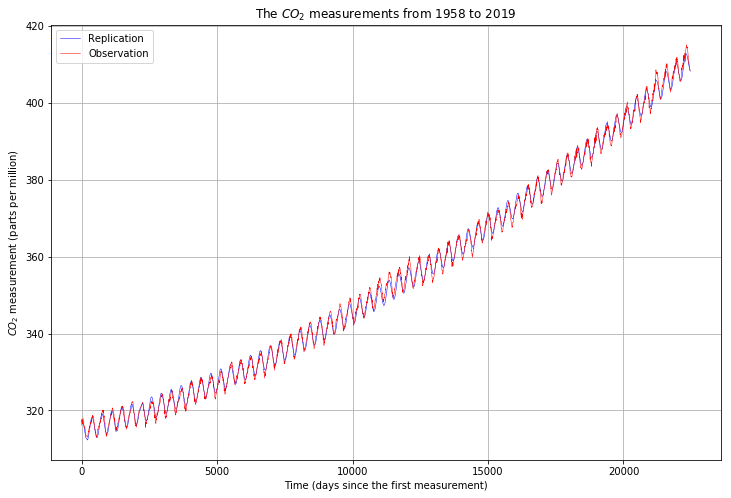

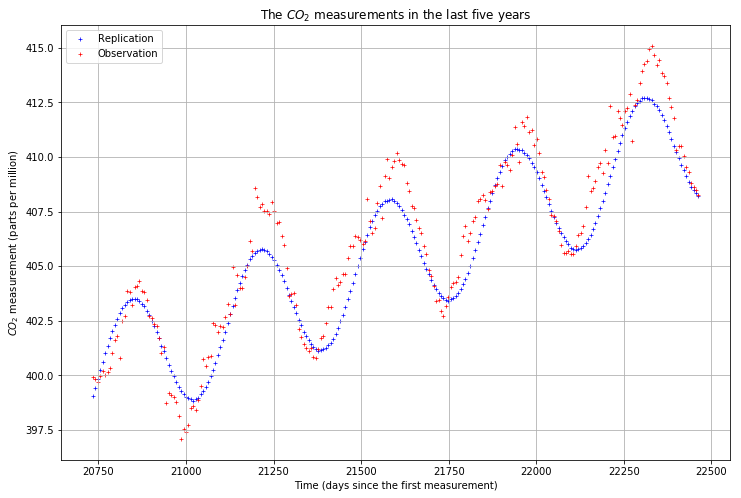

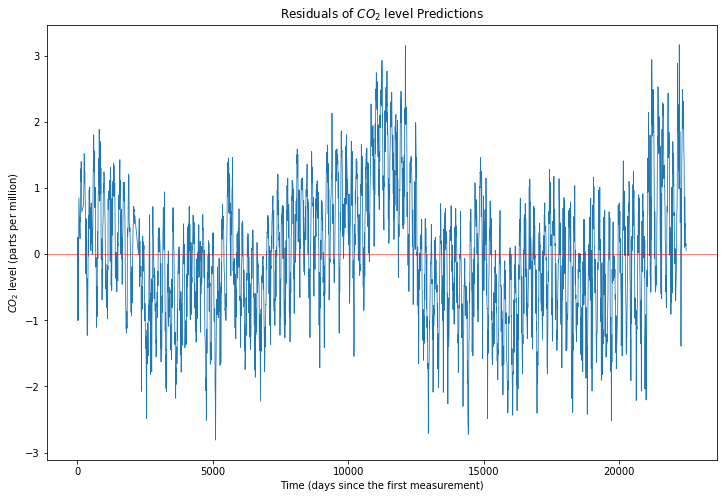

In [54]:
r3 = Stan_results3.extract()
graphing(r3['meas_f'])

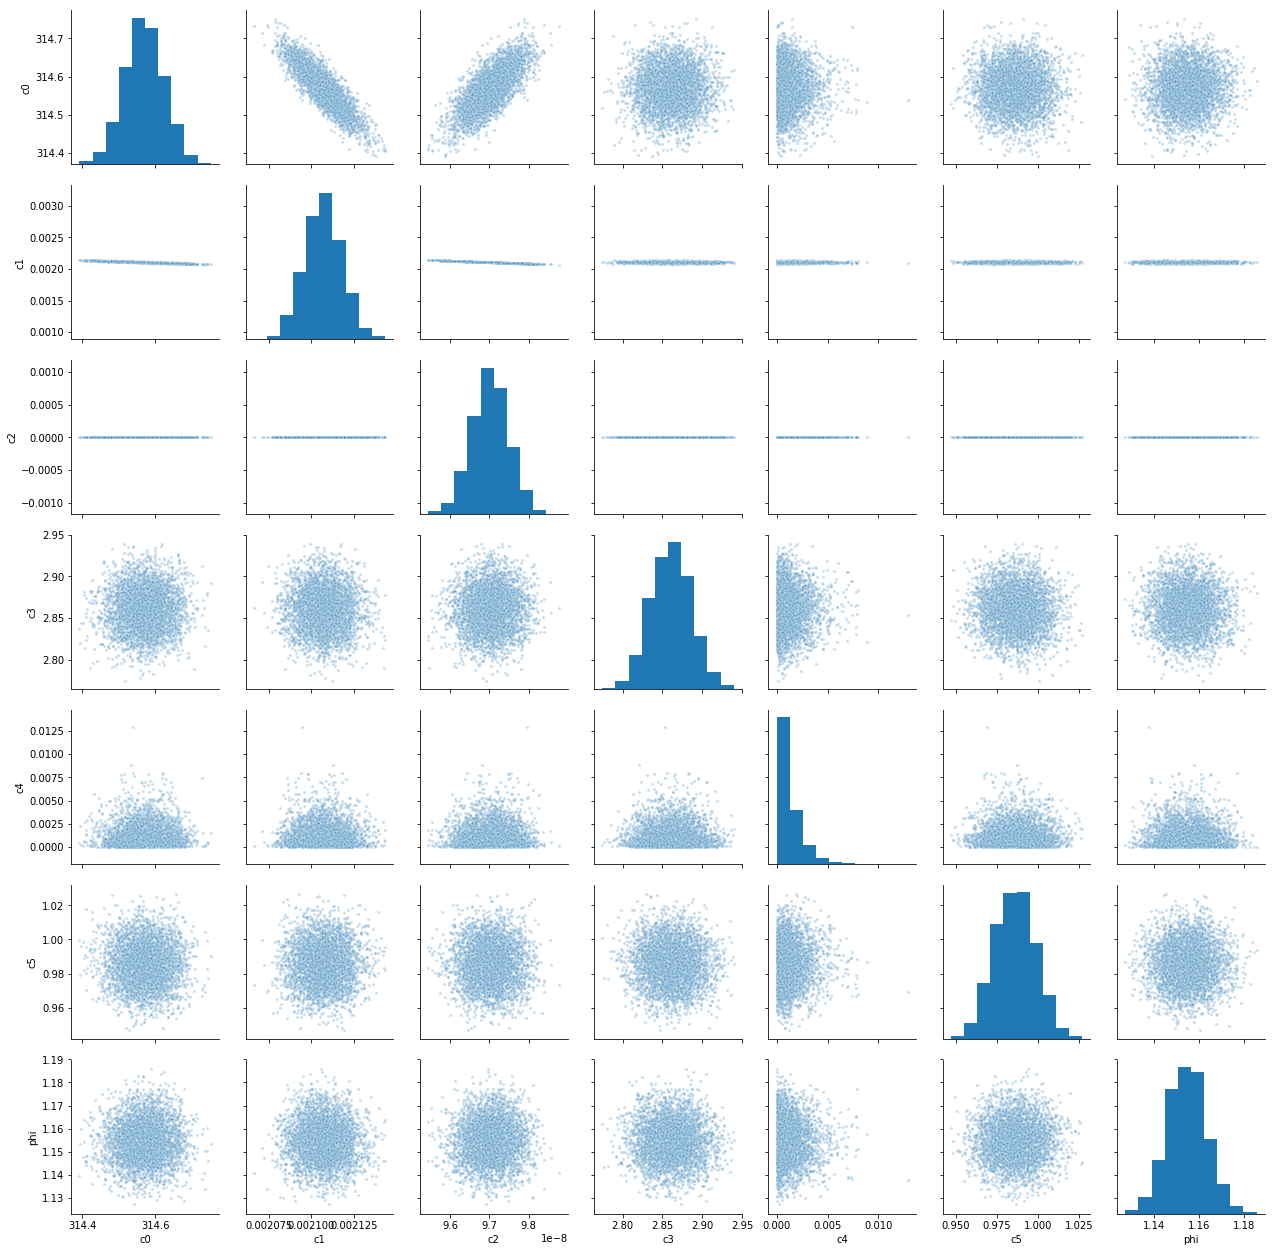

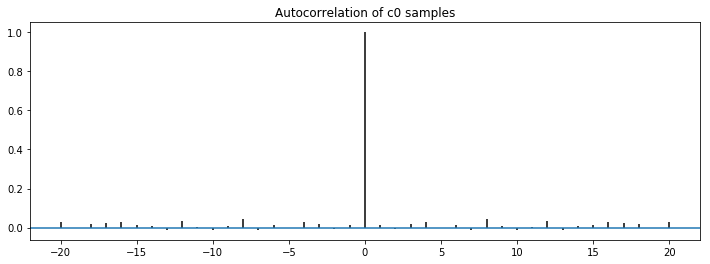

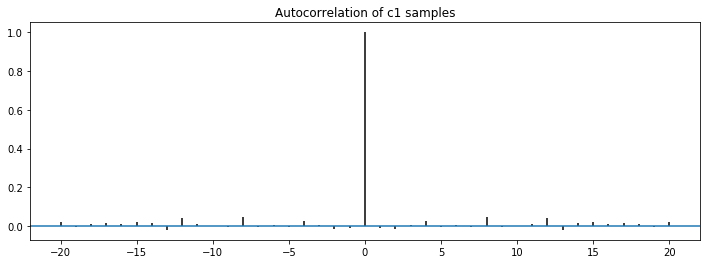

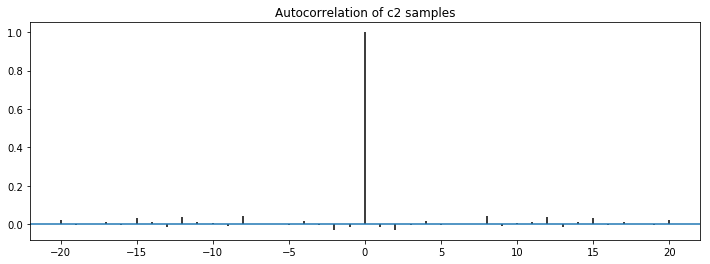

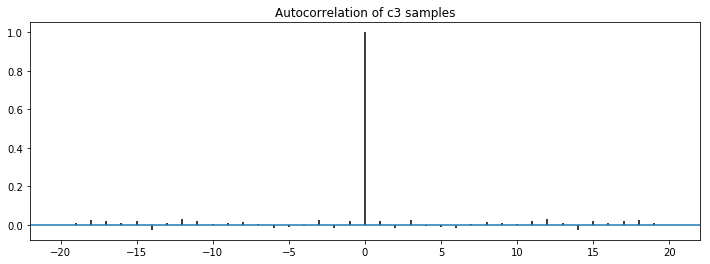

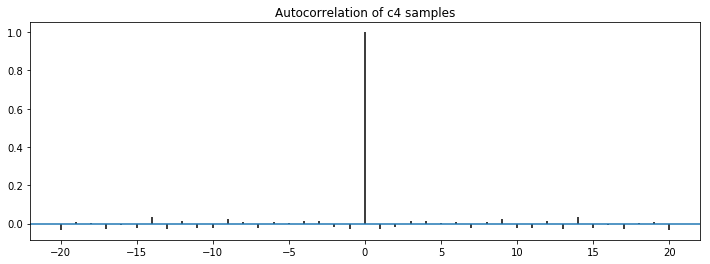

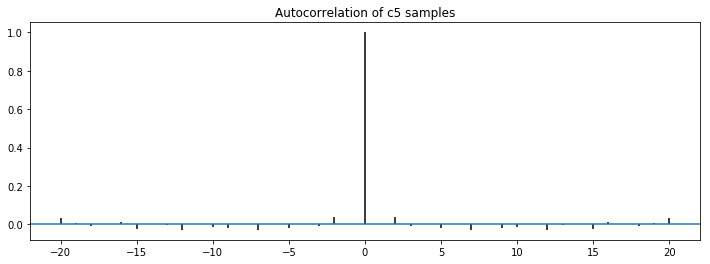

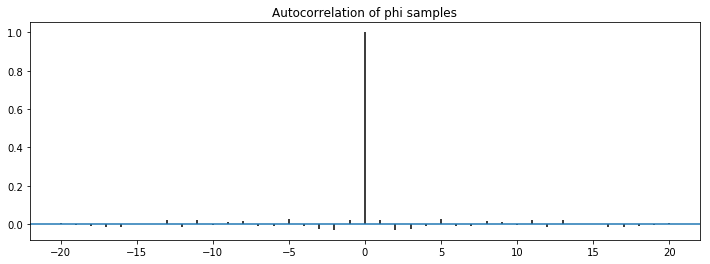

In [34]:
pair_autocorr(r3, param_3)

---

## Confidence intervals

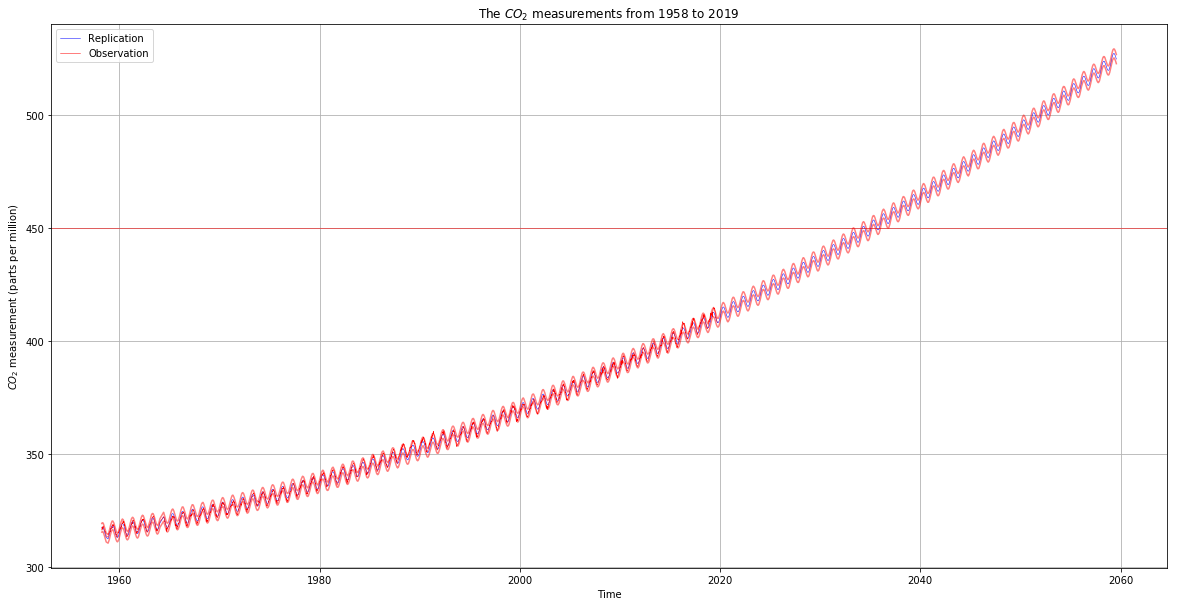

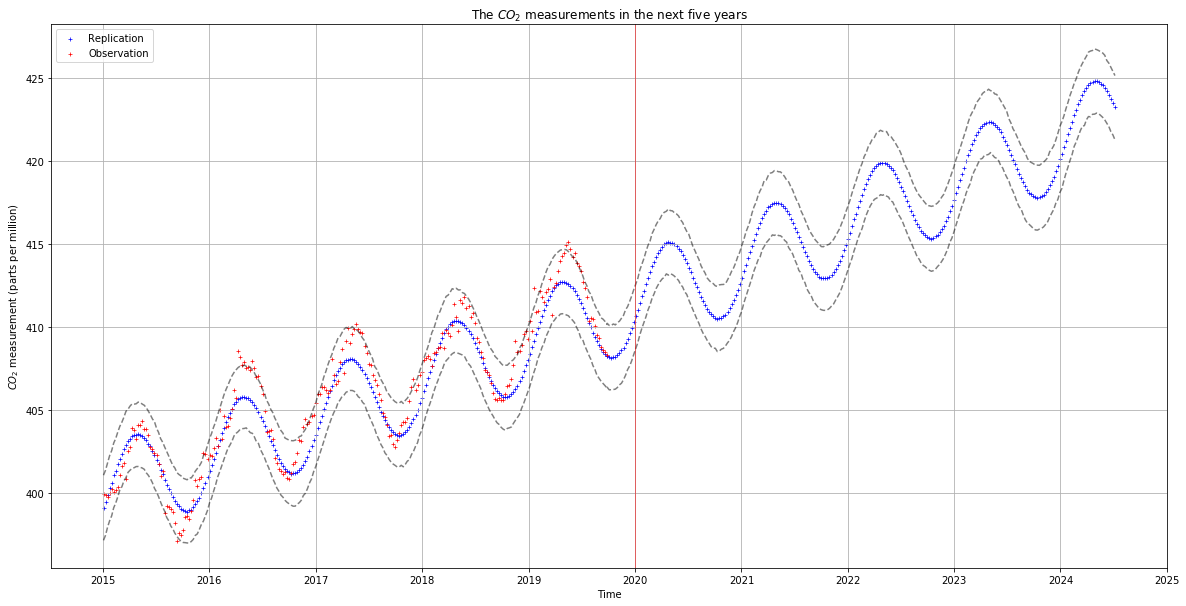

In [123]:
rep_meas, u_bounds, l_bounds = [], [], []
gen_quan = r3['meas_f']
Time = [date(1958,3,29) + 
        timedelta(int(Stan_data['time'][_])) 
        for _ in range(5219)]

for i in range(len(Stan_data['time'])):
    rep_meas.append(np.mean(gen_quan[:,i]))
    u_bounds.append(np.percentile(gen_quan[:,i], 97.5))
    l_bounds.append(np.percentile(gen_quan[:,i], 2.5))


# Plot the whole period
plt.figure(figsize=(20, 10))
plt.plot(Time, rep_meas, label='Replication', 
         linewidth=.5, color='blue')          
plt.plot(Time[:3139], data.Meas, label='Observation',
         linewidth=.5, color='red')
plt.plot(Time, u_bounds, color="red", alpha=0.5)
plt.plot(Time, l_bounds, color="red", alpha=0.5)
plt.axhline(450, color='red', linewidth=.5)
plt.title('The $CO_2$ measurements from 1958 to 2019', 
          fontsize=12)
plt.ylabel('$CO_2$ measurement (parts per million)')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.show()
 
# Plot the next five years
plt.figure(figsize=(20, 10))
plt.scatter(Time[2891:3389], rep_meas[2891:3389], 
            s=10, linewidth=.7, marker='+', color='blue',
            label='Replication')
plt.scatter(Time[2891:3139], data.iloc[2891:3139]['Meas'], 
            s=10, linewidth=.7, marker='+', color='red',
            label='Observation')
plt.plot(Time[2891:3389], u_bounds[2891:3389], 
         color="black", alpha=0.5, ls='--')
plt.plot(Time[2891:3389], l_bounds[2891:3389], 
         color="black", alpha=0.5, ls='--')
plt.axvline(date(2020, 1, 1), color='red', linewidth=.5)
plt.title('The $CO_2$ measurements in the next five years', 
          fontsize=12)
plt.ylabel('$CO_2$ measurement (parts per million)')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.show()

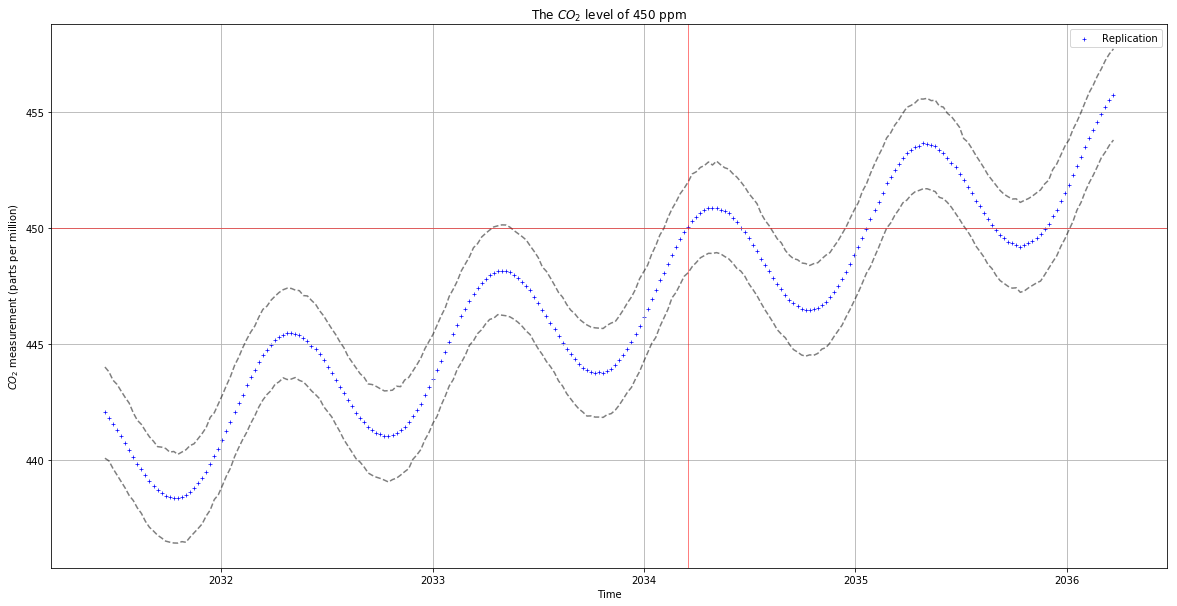

In [145]:
plt.figure(figsize=(20, 10))
plt.scatter(Time[3750:4000], rep_meas[3750:4000], 
            s=10, linewidth=.7, marker='+', color='blue',
            label='Replication')
plt.plot(Time[3750:4000], u_bounds[3750:4000], 
         color="black", alpha=0.5, ls='--')
plt.plot(Time[3750:4000], l_bounds[3750:4000], 
         color="black", alpha=0.5, ls='--')
plt.axvline(date(2034,3,18), color='red', linewidth=.5)
plt.axhline(450, color='red', linewidth=.5)
plt.title('The $CO_2$ level of 450 ppm',
          fontsize=12)
plt.ylabel('$CO_2$ measurement (parts per million)')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.show()

---

## Using Prophet by Facebook

In [38]:
from fbprophet import Prophet
# Importing the data
dataset = pd.read_csv('weekly_in_situ_co2_mlo.csv', 
                      skiprows = list(range(44)),
                      names=['ds', 'y'])

model = Prophet()
model.fit(dataset)
# Projecting the weekly Carbon Dioxide level for 40 years
future = model.make_future_dataframe(periods=2080, freq='w')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5214,2059-07-06,504.441576,426.671616,578.227864,425.414897,576.410062,1.313362,1.313362,1.313362,1.313362,1.313362,1.313362,0.0,0.0,0.0,505.754938
5215,2059-07-13,504.486408,426.058226,577.342270,425.452665,576.490543,0.872242,0.872242,0.872242,0.872242,0.872242,0.872242,0.0,0.0,0.0,505.358650
5216,2059-07-20,504.531241,425.725846,577.074775,425.490432,576.599739,0.414923,0.414923,0.414923,0.414923,0.414923,0.414923,0.0,0.0,0.0,504.946164
5217,2059-07-27,504.576073,425.181194,577.042522,425.528200,576.723210,-0.040995,-0.040995,-0.040995,-0.040995,-0.040995,-0.040995,0.0,0.0,0.0,504.535078
5218,2059-08-03,504.620906,424.871131,576.142380,425.499984,576.846680,-0.503459,-0.503459,-0.503459,-0.503459,-0.503459,-0.503459,0.0,0.0,0.0,504.117447


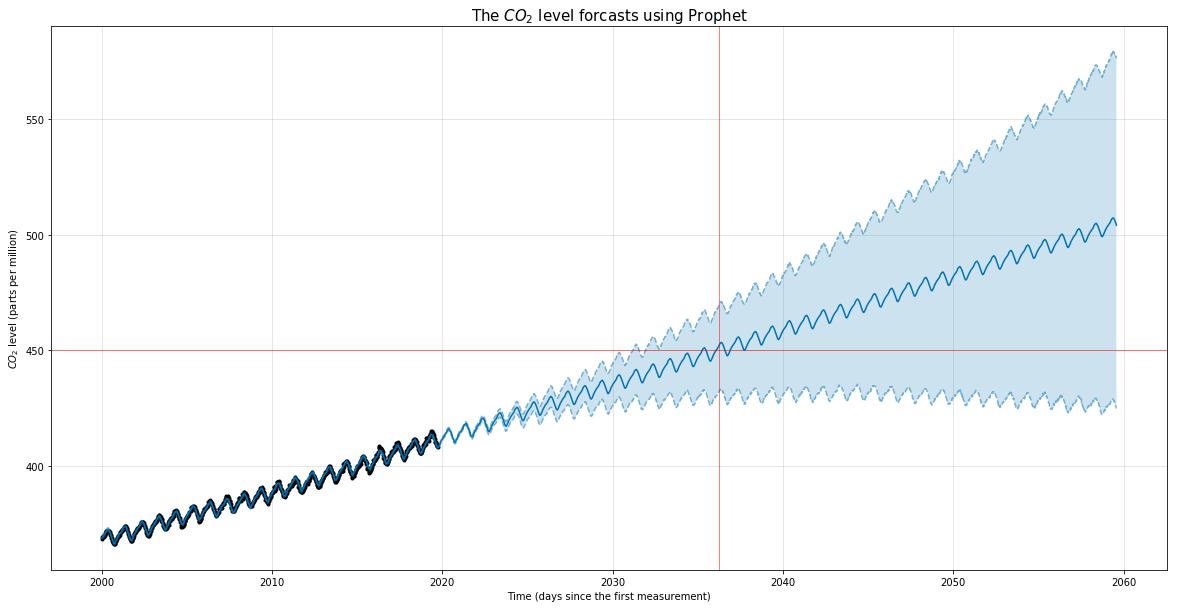

In [170]:
plt.figure(facecolor='w', figsize=(20, 10))

plt.plot(model.history['ds'][2121:],
         model.history['y'][2121:], 'k.')
plt.plot(forecast['ds'][2121:], 
         forecast['yhat'][2121:], ls='-', 
         c=forecast_color)

plt.plot(
    forecast['ds'][2121:],
    forecast['yhat_lower'][2121:],
    ls='--',
    c=forecast_color,
    alpha=0.5)

plt.plot(
    forecast['ds'][2121:],
    forecast['yhat_upper'][2121:],
    ls='--',
    c=forecast_color,
    alpha=0.5)

plt.fill_between(
    forecast['ds'][2121:].values,
    forecast['yhat_lower'][2121:],
    forecast['yhat_upper'][2121:],
    facecolor=forecast_color,
    alpha=0.2)
plt.axhline(450, color='red', linewidth=.5)
plt.axvline(date(2036,3,30), color='red', linewidth=.5)
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel('Time (days since the first measurement)')
plt.ylabel('$CO_2$ level (parts per million)')
plt.title('The $CO_2$ level forcasts using Prophet', 
          fontsize=15)
plt.show()

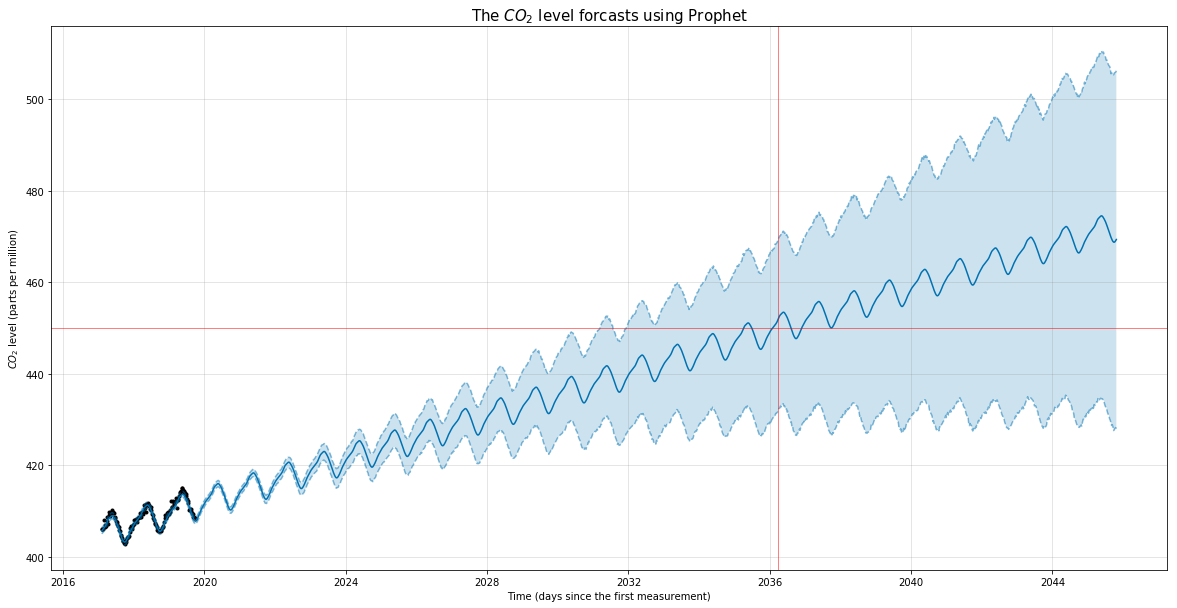

In [171]:
plt.figure(facecolor='w', figsize=(20, 10))

plt.plot(model.history['ds'][3000:],
         model.history['y'][3000:], 'k.')
plt.plot(forecast['ds'][3000:4500], 
         forecast['yhat'][3000:4500], ls='-', 
         c=forecast_color)

plt.plot(
    forecast['ds'][3000:4500],
    forecast['yhat_lower'][3000:4500],
    ls='--',
    c=forecast_color,
    alpha=0.5)

plt.plot(
    forecast['ds'][3000:4500],
    forecast['yhat_upper'][3000:4500],
    ls='--',
    c=forecast_color,
    alpha=0.5)

plt.fill_between(
    forecast['ds'][3000:4500].values,
    forecast['yhat_lower'][3000:4500],
    forecast['yhat_upper'][3000:4500],
    facecolor=forecast_color,
    alpha=0.2)
plt.axhline(450, color='red', linewidth=.5)
plt.axvline(date(2036,3,30), color='red', linewidth=.5)
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel('Time (days since the first measurement)')
plt.ylabel('$CO_2$ level (parts per million)')
plt.title('The $CO_2$ level forcasts using Prophet', 
          fontsize=15)
plt.show()